<a href="https://colab.research.google.com/github/XNN19/CCN2024/blob/main/ContinualLearning/Tutorial_ContinualLearning_CCN2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hands-on tutorial: Continual Learning and Catastrophic Forgetting

**You can make your own copy of this notebook by selecting File->Save a copy in Drive from the menu bar above.**

Things you'll learn in this session:
- To set up a simple continual learning experiment with deep neural networks.
- To implement examples of three computational strategies for continual learning:
  - parameter regularization (illustrated with EWC);
  - replay (illustrated with ER);
  - functional regularization (illustrated with LwF).
- That the type of continual learning problem can have a large influence on the relative efficacy of different strategies.
- BONUS PART: Successful continual learning methods can still suffer *temporary* forgetting.

This tutorial is based on code from this repository: https://github.com/GMvandeVen/continual-learning.

Other popular libraries for continual learning are [Avalanche](https://github.com/ContinualAI/avalanche) and [Mammoth](https://github.com/aimagelab/mammoth).

## Setup
For this tutorial we will use [PyTorch](https://pytorch.org/) as our main deep learning library, and we will use the [MNIST dataset](http://yann.lecun.com/exdb/mnist/) to construct different types of continual learning experiments.

Let's load this dataset and the libraries we need, and we will also already define some visualization functions that we will need later. Because understanding these steps is not critical for following the remainder of this tutorial, these steps are done in 'hidden code blocks'.

Although they are hidden, **it is important that these code blocks are executed!** As we need the results of these steps later. To execute a code block, either press the 'Play'-symbol or select the cell and hitting 'Enter'.

If you want to have a look at the code in a hidden code block, you can click on "Show code".

In [ ]:
#@title Load libraries
# Standard libraries
import numpy as np
import copy
import tqdm
# Pytorch
import torch
from torch.nn import functional as F
from torchvision import datasets, transforms
# For visualization
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [ ]:
#@title Download data
MNIST_trainset = datasets.MNIST(root='data/', train=True, download=True,
                                transform=transforms.ToTensor())
MNIST_testset = datasets.MNIST(root='data/', train=False, download=True,
                               transform=transforms.ToTensor())
config = {'size': 28, 'channels': 1, 'classes': 10}

(When executing the above code block, you might get an error printed to screen saying: `Failed to download (trying next): HTTP Error 403: Forbidden`.
If this happens, PyTorch will usually automatically try to download the dataset somewhere else. If, after the above error, you also see a message containing: `Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz.
100%|██████████|`, then it should be fine and you can safely continue.)

In [ ]:
#@title Visualization functions
def multi_context_barplot(axis, accs, title=None):
    '''Generate barplot using the values in [accs].'''
    contexts = len(accs)
    axis.bar(range(contexts), accs, color='k')
    axis.set_ylabel('Testing Accuracy (%)')
    axis.set_xticks(range(contexts), [f'Context {i+1}' for i in range(contexts)])
    axis.set_ylim(0,100)
    if title is not None:
        axis.set_title(title)

def plot_examples(axis, dataset, context_id=None, n_samples=25):
    '''Plot [n_samples] examples from [dataset].'''
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=n_samples, shuffle=True)
    image_tensor, _ = next(iter(data_loader))
    image_grid = make_grid(image_tensor, nrow=5, pad_value=1) # pad_value=0 would give black borders
    axis.imshow(np.transpose(image_grid.numpy(), (1,2,0)))
    if context_id is not None:
        axis.set_title("Context {}".format(context_id+1))
    axis.axis('off')

def plot_lines(list_with_lines, x_axes=None, line_names=None, colors=None, title=None,
               title_top=None, xlabel=None, ylabel=None, ylim=None, figsize=None,
               with_dots=False, linestyle='solid', v_line=None, v_label=None):
    '''Generate a figure containing multiple lines in one plot.

    :param list_with_lines: <list> of all lines to plot (with each line being a <list> as well)
    :param x_axes:          <list> containing the values for the x-axis
    :param line_names:      <list> containing the names of each line
    :param colors:          <list> containing the colors of each line
    :param title:           <str> title of plot
    :param title_top:       <str> text to appear on top of the title
    :return: f:             <figure>
    '''

    # if needed, generate default x-axis
    if x_axes == None:
        n_obs = len(list_with_lines[0])
        x_axes = list(range(n_obs))

    # if needed, generate default line-names
    if line_names == None:
        n_lines = len(list_with_lines)
        line_names = ["line " + str(line_id) for line_id in range(n_lines)]

    # make plot
    size = (12,7) if figsize is None else figsize
    f, axarr = plt.subplots(1, 1, figsize=size)

    # mean lines
    for line_id, name in enumerate(line_names):
        axarr.plot(x_axes, list_with_lines[line_id], label=name,
                   color=None if (colors is None) else colors[line_id],
                   linewidth=4, marker='o' if with_dots else None,
                   linestyle=linestyle if type(linestyle)==str else linestyle[line_id])

    # add vertical line
    if v_line is not None:
        axarr.axvline(x=v_line, label=v_label, color='black')

    # finish layout
    # -set y-axis
    if ylim is not None:
        axarr.set_ylim(ylim)
    # -add axis-labels
    if xlabel is not None:
        axarr.set_xlabel(xlabel)
    if ylabel is not None:
        axarr.set_ylabel(ylabel)
    # -add title(s)
    if title is not None:
        axarr.set_title(title)
    if title_top is not None:
        f.suptitle(title_top)
    # -add legend
    if line_names is not None:
        axarr.legend()

    # return the figure
    return f

## **Part 1:** Catastrophic forgetting
Let's start by setting up a simple continual learning experiment with deep neural networks, to check whether there is indeed catastrophic forgetting.

### Set up the benchmark: Permuted MNIST
To start with, we will use "Permuted MNIST". In this continual learning benchmark, in each context (or task), the neural network must learn to classify the ten MNIST digits. However, in each context a different permutation is applied to the pixels of all images.

Permuted MNIST was first used in this paper: https://arxiv.org/abs/1312.6211.

Let's start by specifying some "helper functions" that we will use to create the various contexts (or tasks) of Permuted MNIST.

As before, the code for these helper functions is hidden, but you can look at it if you are interested. **Either way, it is again needed to run the code in the below cell!**

In [ ]:
#@title Helper functions

# Function to apply a given permutation the pixels of an image.
def permutate_image_pixels(image, permutation):
    '''Permutate the pixels of [image] according to [permutation].'''

    if permutation is None:
        return image
    else:
        c, h, w = image.size()
        image = image.view(c, -1)
        image = image[:, permutation]  #--> same permutation for each channel
        image = image.view(c, h, w)
        return image

# Class to create a dataset with images that have all been transformed in the same way.
class TransformedDataset(torch.utils.data.Dataset):
    '''To modify an existing dataset with a transform.
    Useful for creating different permutations of MNIST without loading the data multiple times.'''

    def __init__(self, original_dataset, transform=None, target_transform=None):
        super().__init__()
        self.dataset = original_dataset
        self.transform = transform
        self.target_transform = target_transform
        if hasattr(original_dataset, "targets"):
            self.targets = original_dataset.targets if target_transform is None else [
                target_transform(i) for i in original_dataset.targets
            ]

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        (input, target) = self.dataset[index]
        if self.transform:
            input = self.transform(input)
        if self.target_transform:
            target = self.target_transform(target)
        return (input, target)

Now let's use these tools to create a Permuted MNIST benchmark with 2 contexts.

In [ ]:
# Choose the number of contexts (or "tasks") to create
contexts = 2

In [ ]:
# Specify for each context the permutations to use (with no permutation for the first context)
permutations = [None] + [np.random.permutation(config['size']**2) for _ in range(contexts-1)]

In [ ]:
# Specify for each context the transformed train- and testset
train_datasets = []
test_datasets = []
for context_id, perm in enumerate(permutations):
    train_datasets.append(TransformedDataset(
        MNIST_trainset, transform=transforms.Lambda(lambda x, p=perm: permutate_image_pixels(x, p)),
    ))
    test_datasets.append(TransformedDataset(
        MNIST_testset, transform=transforms.Lambda(lambda x, p=perm: permutate_image_pixels(x, p)),
    ))

In [ ]:
# Visualize the contexts
figure, axis = plt.subplots(1, contexts, figsize=(3*contexts, 4))

for context_id in range(len(train_datasets)):
    plot_examples(axis[context_id], train_datasets[context_id], context_id=context_id)

### Set up the model
Now it is time to define the deep neural network model that we will sequentially train on these two contexts.

We start again by specifying some "helper functions" that make it easier to specify the model.

In [ ]:
#@title Helper functions

def count_parameters(model):
    '''Count number of parameters in [model], and print to screen.'''
    total_params = 0
    for param in model.parameters():
        n_params = index_dims = 0
        for dim in param.size():
            n_params = dim if index_dims==0 else n_params*dim
            index_dims += 1
        total_params += n_params
    print( "--> this network has {} trainable parameters (~{}K)"
          .format(total_params, round(total_params / 1000)))


class Identity(torch.nn.Module):
    '''A nn-module to simply pass on the input data.'''
    def forward(self, x):
        return x

    def __repr__(self):
        tmpstr = self.__class__.__name__ + '()'
        return tmpstr


class Flatten(torch.nn.Module):
    '''A nn-module to flatten a multi-dimensional tensor to 2-dim tensor.'''
    def forward(self, x):
        batch_size = x.size(0)   # first dimenstion should be batch-dimension.
        return x.view(batch_size, -1)

    def __repr__(self):
        tmpstr = self.__class__.__name__ + '()'
        return tmpstr


class fc_layer(torch.nn.Module):
    '''Fully connected layer, with possibility of returning "pre-activations".

    Input:  [batch_size] x ... x [in_size] tensor
    Output: [batch_size] x ... x [out_size] tensor'''

    def __init__(self, in_size, out_size, nl=torch.nn.ReLU(), bias=True):
        super().__init__()
        self.bias = bias
        self.linear = torch.nn.Linear(in_size, out_size, bias=bias)
        if isinstance(nl, torch.nn.Module):
            self.nl = nl
        elif nl=="relu":
            self.nl = torch.nn.ReLU()
        elif nl=="leakyrelu":
          self.nl = torch.nn.LeakyReLU()

    def forward(self, x):
        pre_activ = self.linear(x)
        output = self.nl(pre_activ) if hasattr(self, 'nl') else pre_activ
        return output


class MLP(torch.nn.Module):
    '''Module for a multi-layer perceptron (MLP).

    Input:  [batch_size] x ... x [size_per_layer[0]] tensor
    Output: (tuple of) [batch_size] x ... x [size_per_layer[-1]] tensor'''

    def __init__(self, input_size=1000, output_size=10, layers=2,
                 hid_size=1000, hid_smooth=None, size_per_layer=None,
                 nl="relu", bias=True, output='normal'):
        '''sizes: 0th=[input], 1st=[hid_size], ..., 1st-to-last=[hid_smooth], last=[output].
        [input_size]       # of inputs
        [output_size]      # of units in final layer
        [layers]           # of layers
        [hid_size]         # of units in each hidden layer
        [hid_smooth]       if None, all hidden layers have [hid_size] units, else # of units linearly in-/decreases s.t.
                             final hidden layer has [hid_smooth] units (if only 1 hidden layer, it has [hid_size] units)
        [size_per_layer]   None or <list> with for each layer number of units (1st element = number of inputs)
                                --> overwrites [input_size], [output_size], [layers], [hid_size] and [hid_smooth]
        [nl]               <str>; type of non-linearity to be used (options: "relu", "leakyrelu", "none")
        [output]           <str>; if - "normal", final layer is same as all others
                                     - "none", final layer has no non-linearity
                                     - "sigmoid", final layer has sigmoid non-linearity'''

        super().__init__()
        self.output = output

        # get sizes of all layers
        if size_per_layer is None:
            hidden_sizes = []
            if layers > 1:
                if (hid_smooth is not None):
                    hidden_sizes = [int(x) for x in np.linspace(hid_size, hid_smooth, num=layers-1)]
                else:
                    hidden_sizes = [int(x) for x in np.repeat(hid_size, layers - 1)]
            size_per_layer = [input_size] + hidden_sizes + [output_size] if layers>0 else [input_size]
        self.layers = len(size_per_layer)-1

        # set label for this module
        # -determine "non-default options"-label
        nd_label = "{bias}{nl}".format(
            bias="" if bias else "n",
            nl="l" if nl=="leakyrelu" else ("n" if nl=="none" else ""),
        )
        nd_label = "{}{}".format("" if nd_label=="" else "-{}".format(nd_label),
                                 "" if output=="normal" else "-{}".format(output))
        # -set label
        size_statement = ""
        for i in size_per_layer:
            size_statement += "{}{}".format("-" if size_statement=="" else "x", i)
        self.label = "F{}{}".format(size_statement, nd_label) if self.layers>0 else ""

        # set layers
        for lay_id in range(1, self.layers+1):
            # number of units of this layer's input and output
            in_size = size_per_layer[lay_id-1]
            out_size = size_per_layer[lay_id]
            # define and set the fully connected layer
            layer = fc_layer(
                in_size, out_size, bias=bias,
                nl=("none" if output=="none" else nn.Sigmoid()) if (
                    lay_id==self.layers and not output=="normal"
                ) else nl,
            )
            setattr(self, 'fcLayer{}'.format(lay_id), layer)

        # if no layers, add "identity"-module to indicate in this module's representation nothing happens
        if self.layers<1:
            self.noLayers = Identity()

    def forward(self, x):
        for lay_id in range(1, self.layers + 1):
            x = getattr(self, "fcLayer{}".format(lay_id))(x)
        return x

    @property
    def name(self):
        return self.label

Then let's specify a class for a basic neural network classifier model.

In [ ]:
class Classifier(torch.nn.Module):
    '''Model for classifying images.'''

    def __init__(self, image_size, image_channels, output_units,
                 fc_layers=3, fc_units=1000):

        super().__init__()

       # Flatten image to 2D-tensor
        self.flatten = Flatten()

        # Specify the fully connected hidden layers
        input_size = image_channels * image_size * image_size
        self.fcE = MLP(input_size=input_size, output_size=fc_units,
                       layers=fc_layers-1, hid_size=fc_units)
        mlp_output_size = fc_units if fc_layers>1 else self.input_size

        # Specify the final linear classifier layer
        self.classifier = fc_layer(mlp_output_size, output_units, nl='none')

    def forward(self, x):
        flatten_x = self.flatten(x)
        final_features = self.fcE(flatten_x)
        out = self.classifier(final_features)
        return out

Let's create an instance of such a classifier model, and print some details of it to screen.

In [ ]:
# Specify the architectural layout of the network to use
fc_lay = 4        #--> number of fully-connected layers
fc_units = 40     #--> number of units in each hidden layer

In [ ]:
# Define the model
model = Classifier(image_size=config['size'], image_channels=config['channels'],
                   output_units=config['classes'],
                   fc_layers=fc_lay, fc_units=fc_units)

In [ ]:
# Print the network architecture
model

In [ ]:
# Print info regarding number of parameters
count_parameters(model)

### Train on first context
It's time to start training the model on the first context (i.e., the regular MNIST dataset).

To do this, let's define a function to that can train a given neural network (i.e., `model`) on a particular dataset (i.e., `dataset`). We can then later re-use this function, for example to train the network on the dataset of the second context.

Let's set up the training function such that we can also specify the number of iterations we want to train for (`iters`), the learning rate (`lr`) and the mini batch-size (`batch_size`):

In [ ]:
def train(model, dataset, iters, lr, batch_size):
    '''Function to train a [model] on a given [dataset].'''

    # Define the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))

    # Set model in training-mode
    model.train()

    # Initialize # iters left on current data-loader
    iters_left = 1

    # Define progress bar -- this will print information about progress of training to screen
    progress_bar = tqdm.tqdm(range(1, iters+1))

    # Loop over all iterations
    for batch_index in range(1, iters+1):

        # Update # iters left on current data-loader and, if needed, create new one
        iters_left -= 1
        if iters_left==0:
            data_loader = iter(torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                          shuffle=True, drop_last=True))
            iters_left = len(data_loader)

        # Sample training data of current context
        x, y = next(data_loader)

        # Reset optimizer
        optimizer.zero_grad()

        # Run model
        y_hat = model(x)

        # Calculate prediction loss
        loss = torch.nn.functional.cross_entropy(input=y_hat, target=y, reduction='mean')

        # Calculate training-accuracy (in %)
        accuracy = (y == y_hat.max(1)[1]).sum().item()*100 / x.size(0)

        # Backpropagate errors
        loss.backward()

        # Take the optimizer step
        optimizer.step()

        # Update progress bar
        progress_bar.set_description(
        '<CLASSIFIER> | training loss: {loss:.3} | training accuracy: {prec:.3}% |'
            .format(loss=loss.item(), prec=accuracy)
        )
        progress_bar.update(1)

    # Close the progress bar at the end of training
    progress_bar.close()

Now we need to choose the training hyperparameters (i.e., learning rate, batch size and number of iterations).

In [ ]:
iters = 200       #--> for how many iterations to train?
lr = 0.01         #--> learning rate
batch_size = 128  #--> size of mini-batches

And then let's train our neural network on the first context.

In [ ]:
# Train the model on the first context
train(model, dataset=train_datasets[0], iters=iters, lr=lr, batch_size=batch_size)

#### Evaluate
Did the training work? Let's find out by evaluating the performance of the trained model on the MNIST test set.

To make evaluating the model easier in the future, let's again specify a general function to evaluate any given model (i.e., `model`) on a specific dataset (i.e., `dataset`).

In [ ]:
def test_acc(model, dataset, test_size=None, batch_size=128):
    '''Evaluate accuracy (% samples classified correctly) of a classifier ([model]) on [dataset].'''

    # Set model to eval()-mode
    mode = model.training
    model.eval()

    # Loop over batches in [dataset]
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                              shuffle=True, drop_last=False)
    total_tested = total_correct = 0
    for x, y in data_loader:
        # -break on [test_size] (if "None", the full dataset is used)
        if test_size:
            if total_tested >= test_size:
                break
        # -evaluate model
        with torch.no_grad():
            scores = model(x)
        _, predicted = torch.max(scores, 1)
        # -update statistics
        total_correct += (predicted == y).sum().item()
        total_tested += len(x)
    accuracy = total_correct*100 / total_tested

    # Set model back to its initial mode
    model.train(mode=mode)

    # Return the result
    return accuracy

Now let's use this function to evaluate the performance of the model on both the test data from context 1 (i.e., regular MNIST, on which the model was just trained) and on the test data from context 2 (i.e., a permuted version of MNIST, on which the model has not yet been trained).

In [ ]:
# Evaluate accuracy per context and print to screen
print("\n Accuracy (in %) of the model on the test set of:")
context1_accs = []
for i in range(contexts):
    acc = test_acc(model, test_datasets[i], test_size=None)
    print(" - Context {}: {:.1f}".format(i+1, acc))
    context1_accs.append(acc)

The model does well on test data from context 1, but is around chance level for test data from context 2.

This is not very surprising, as we have not yet trained the model on context 2!

#### Store model copy
Before continuing to train the model on the second context, let's store a copy of the model after training on the first context. We will later use this model copy to try out different ways of training the same model on the second context (i.e., we will try out different continual learning methods).

In [ ]:
model_after_context1 = copy.deepcopy(model)

### Train on second context
Now let's continue to train our model on the second context, and see what happens.

For this, we can re-use the training function that we defined earlier:

In [ ]:
# Continue to train the model on the second context
train(model, dataset=train_datasets[1], iters=iters, lr=lr, batch_size=batch_size)

#### Evaluate
And after this new training phase, let's again evaluate the performance of the model on the test sets of both contexts:

In [ ]:
# Evaluate accuracy per context and print to screen
print("\n Accuracy (in %) of the model on the test set of:")
context2_accs = []
for i in range(contexts):
    acc = test_acc(model, test_datasets[i], test_size=None)
    print(" - Context {}: {:.1f}".format(i+1, acc))
    context2_accs.append(acc)

We thus find that after finishing training on the second context, our model does well on test data from context 2.

But there is quite a drop in the performance of the model on test data from context 1.

Is this catastrophic forgetting? Or could this drop be explained by insufficient capacity of the model to learn both tasks at the same time?

### Train on both contexts at the same time
To test this, we will take a similar deep neural network model as before and train it on both contexts simultaneously.

To do this, we can re-use a lot of the tools we created earlier: the `Classifier` model class, the `train` function and the `test_acc` function.

In [ ]:
# Define a new model with the same architecture
model_joint = Classifier(image_size=config['size'], image_channels=config['channels'],
                         output_units=config['classes'],
                         fc_layers=fc_lay, fc_units=fc_units)

In [ ]:
# Create a joint dataset with data from both contexts
joint_trainset = torch.utils.data.ConcatDataset(train_datasets)

We will use the same training-hyperparameters as before, except that we double the batch size.

In [ ]:
batch_size_joint = 256

In [ ]:
# Train the joint model
train(model_joint, dataset=joint_trainset, iters=iters, lr=lr, batch_size=batch_size_joint)

In [ ]:
# Evaluate the model
print("\n Accuracy (in %) of the model on the test set of:")
joint_accs = []
for i in range(contexts):
    acc = test_acc(model_joint, test_datasets[i], test_size=None)
    print(" - Context {}: {:.1f}".format(i+1, acc))
    joint_accs.append(acc)

### Visualize results

In [ ]:
# Visualize
figure, axis = plt.subplots(1, 4, figsize=(18, 5))

title='After training on context 1, \nbut not yet training on context 2'
multi_context_barplot(axis[0], context1_accs, title)

title='After first training on context 1, \nand then training on context 2'
multi_context_barplot(axis[1], context2_accs, title)

axis[2].axis('off')

title='After jointly training on both contexts'
multi_context_barplot(axis[3], joint_accs, title)

We have observed **catastrophic forgetting**! When our neural network model first learns context 1 and is then trained on context 2, the model's performance on data from context 1 substantially drops (left panels). When the same neural network model is instead trained on both context 1 and context 2 at the same time, the model is able to learn both contexts well (right panel), demonstrating that the forgetting cannot be explained by limited model capacity. The low performance on context 1 is due to the temporal order of the training.

### ***CODING ASSIGNMENT:***  Continually train on three contexts of Permuted MNIST
As an exercise, try to adapt the above code to continually train a deep neural network on a Permuted MNIST benchmark with *three* contexts.

Try to complete the code cell below, wherever it says `...TO BE COMPLETED...`.

TIP: you can re-use many of the functions or classes that we already defined above.

In [ ]:
# Specify the number of contexts
contexts3 = 3 # Let's add a '3' to all new variables we define, to avoid overwriting previous ones

# Specify for each context the permutations to use (again no permutation for the first context)
permutations3 = [None] + [np.random.permutation(config['size']**2) for _ in range(contexts3-1)]

# Specify for each context the transformed train- and testset
train_datasets3 = []
test_datasets3 = []
# ...TO BE COMPLETED...

# Define the model
model3 = None
# ...TO BE COMPLETED...

# Sequentially train the model on all three contexts
for context_id in range(contexts3):
    print('Train on context {}'.format(context_id+1))
    # ...TO BE COMPLETED...

# Evaluate the model
print("\n After finishing training, accuracy (in %) of the model on test-set of:")
accs3 = []
for i in range(contexts3):
    pass
    # ...TO BE COMPLETED...

# Visualize
figure, axis = plt.subplots(1, 1, figsize=(6, 5))
title='After training on all three contexts'
multi_context_barplot(axis, accs3, title)

In [ ]:
#@title Possible Answer

# Specify the number of contexts
contexts3 = 3

# Specify for each context the permutations to use (again no permutation for the first context)
permutations3 = [None] + [np.random.permutation(config['size']**2) for _ in range(contexts3-1)]

# Specify for each context the transformed train- and testset
train_datasets3 = []
test_datasets3 = []
for context_id, perm in enumerate(permutations3):
    train_datasets3.append(TransformedDataset(
        MNIST_trainset, transform=transforms.Lambda(lambda x, p=perm: permutate_image_pixels(x, p)),
    ))
    test_datasets3.append(TransformedDataset(
        MNIST_testset, transform=transforms.Lambda(lambda x, p=perm: permutate_image_pixels(x, p)),
    ))

# Define the model
model3 = Classifier(image_size=config['size'], image_channels=config['channels'],
                   output_units=config['classes'],
                   fc_layers=fc_lay, fc_units=fc_units)

# Sequentially train the model on all three contexts
for context_id in range(contexts3):
    print('Train on context {}'.format(context_id+1))
    train(model3, dataset=train_datasets3[context_id], iters=iters, lr=lr, batch_size=batch_size)

# Evaluate the model
print("\n After finishing training, accuracy (in %) of the model on test-set of:")
accs3 = []
for i in range(contexts3):
    acc = test_acc(model3, test_datasets3[i], test_size=None)
    print(" - Context {}: {:.1f}".format(i+1, acc))
    accs3.append(acc)

# Visualize
figure, axis = plt.subplots(1, 1, figsize=(6, 5))
title='After training on all three contexts'
multi_context_barplot(axis, accs3, title)

## **Part 2:** Overcoming catastrophic forgetting
Now that we found catastrophic forgetting, let's explore some computational strategies to mitigate the forgetting.

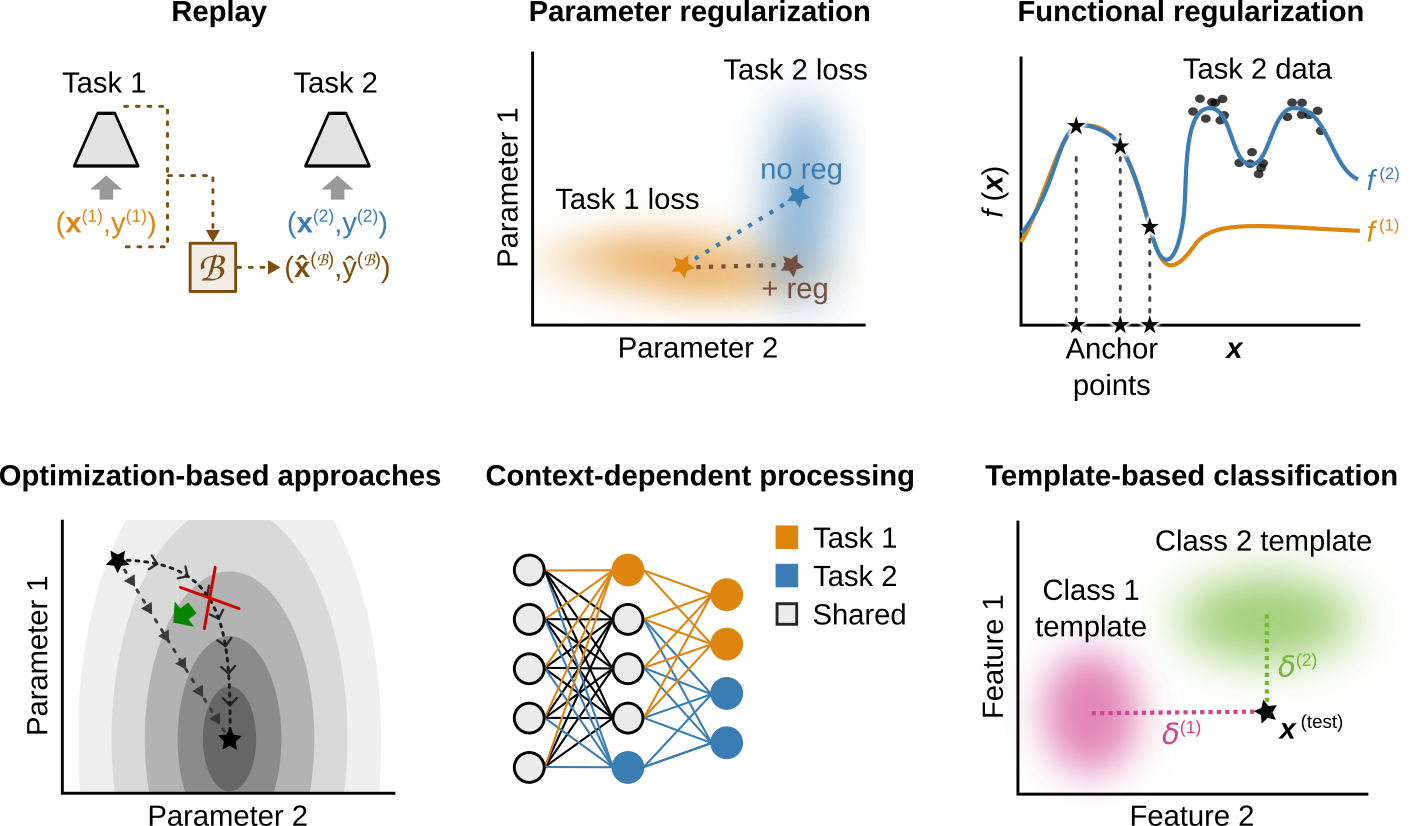

In the keynote, Dhireesha discussed six computational strategies for continual learning (see figure above, which is from [this bookchapter](https://arxiv.org/abs/2403.05175)).

In this tutorial, we will implement examples of the three most popular computational strategies: parameter regularization (illustrated by EWC), functional regularization (illustrated by LwF) and replay (illustrated by ER).

For all these strategies, the training on the first context is the same as before. We can therefore use as starting point the copy of the model that we stored after finishing training on the first context:

In [ ]:
model_ewc = copy.deepcopy(model_after_context1)
model_replay = copy.deepcopy(model_after_context1)
model_lwf = copy.deepcopy(model_after_context1)

#### Parameter Regularization: EWC
With parameter regularization, a penalty term is added to the loss to encourage parameters important for past contexts not to change too much during continued training.

A popular parameter regularization strategy for continual learning with deep neural networks is Elastic Weight Consolidation (EWC). It was introduced in the paper "[Overcoming catastrophic forgetting in neural networks
](https://www.pnas.org/doi/abs/10.1073/pnas.1611835114)" (Kirkpatrick et al., 2017; *PNAS*).

EWC computes a diagonal approximation to the [Fisher Information matrix](https://en.wikipedia.org/wiki/Fisher_information) to estimate for each parameter of the network how important it is for the performance on the previous context. During training on the next context, these parameter importance estimates are then used to penalize changes to the parameters, with changes to the most important parameters penalized most.

When training on context $k>1$, the loss function optimized by EWC is given by:
$$
\mathcal{L}_{\text{total}}\left(\boldsymbol{\theta}\right) = \mathcal{L}_{\text{current}}\left(\boldsymbol{\theta}\right) + λ \mathcal{L}^{(k)}_{\text{regularization}_{\text{EWC}}}\left(\boldsymbol{\theta}\right)
$$

Here $\mathcal{L}_{\text{current}}\left(\boldsymbol{\theta}\right)$ is the loss on the data of the current context, $λ$ is a hyperparameter, and the EWC regularization term is given by:
$$
\mathcal{L}^{(k)}_{\text{regularization}_{\text{EWC}}}\left(\boldsymbol{\theta}\right) = \frac{1}{2} \sum_{i=1}^{N_{\text{params}}} \tilde{F}_{ii}^{(k)} \left(\theta_i - \hat{\theta}_{i}^{(k)} \right)^2
$$
whereby $\hat{\theta}_{i}^{(k)}$ is the $i^{\text{th}}$ element of $\hat{\boldsymbol{\theta}}^{\left(k\right)}$, which is the vector with parameter values at the end of training of task $k$, and $\tilde{F}_{ii}^{(k)}$ is an approximation of $F_{ii}^{(k)}$, the $i^{\text{th}}$ diagonal element of $\boldsymbol{F}^{(k)}$, which is the Fisher Information matrix of task $k$ evaluated at $\hat{\boldsymbol{\theta}}^{(k)}$.

(Technically, the above regularization term is for `[Online EWC](https://arxiv.org/abs/1805.06370)'. The original version of EWC did something weird, as explained in [this blog post](https://www.inference.vc/comment-on-overcoming-catastrophic-forgetting-in-nns-are-multiple-penalties-needed-2/).)

##### Bayesian interpretation
EWC, as well as many other parameter regularization methods, can be interpreted as performing sequential approximate Bayesian inference on the parameters of a neural network. When learning a new task, the prior distribution over the parameters is given by a Gaussian with mean equal to the optimal parameters found at the end of training on the previous task and variance equal to the inverse of the approximated Fisher Information matrix. See for example [this paper](https://arxiv.org/abs/2105.04093) or [this paper](https://arxiv.org/abs/1902.06494) for insightful treatments of this interpretation.

Note that according to this Bayesian interpretation of EWC, the value of hyperparameter $\lambda$ should be 1. In practice, however, values of $\lambda$ are used that can be orders of magnitude larger.

##### Computation of Fisher Infomation

The Fisher Information matrix is defined as the covariance of the `score', which is the partial derivative with respect to $\boldsymbol{\theta}$ of the natural logarithm of the likelihood function. The $i^{\text{th}}$ diagonal element of the Fisher Information on context $k$ is therefore given by:

$$
F_{ii}^{(k)} = \mathbb{E}_{\boldsymbol{x}\sim Q_{\boldsymbol{x}}^{(k)}} \left[ \ \mathbb{E}_{p_{\hat{\boldsymbol{\theta}}^{(k)}}} \left[ \left(  \left. \frac{\delta \log{p_{\boldsymbol{\theta}}\left(Y=y|\boldsymbol{x}\right)}}{\delta \theta_i} \right\rvert_{\boldsymbol{\theta}=\hat{\boldsymbol{\theta}}^{(k)}} \right)^2 \right] \right]
$$

whereby $Q_{\boldsymbol{x}}^{(k)}$ is the input distribution of context $k$, $p_{\boldsymbol{\theta}}$ is the conditional distribution of $y$ given $\boldsymbol{x}$ defined by the neural network with parameters $\boldsymbol{\theta}$, and $\hat{\boldsymbol{\theta}}^{(k)}$ is the vector with parameter values after finisihing training on context $k$.

The outer expectation in the above equation can be approximated using a random sample from the training set of context $k$. Because there is only a finite number of possible classes, the inner expectation in the above equation can be calculated for each sample exactly:
$$
\tilde{F}_{ii}^{(k)} = \frac{1}{|S^{(k)}|} \sum_{\boldsymbol{x}\in S^{(k)}} \left( \sum_{c=1}^{N_{\text{classes}}} \tilde{y}_c \left( \left. \frac{\delta\log p_{\boldsymbol{\theta}}\left(Y=c|\boldsymbol{x}\right)}{\delta\theta_i} \right\rvert_{\boldsymbol{\theta}=\hat{\boldsymbol{\theta}}^{(k)}} \right)^2 \right)
$$
whereby $S^{(k)}$ is the random sample of training data of context $k$ and $\tilde{y}_c = p_{\hat{\boldsymbol{\theta}}^{(k)}}\left(Y=c|\boldsymbol{x}\right)$ (i.e., the probability that input $\boldsymbol{x}$ belongs to class $c$ as predicted by the model after finishing training on context $k$).

**In the literature or on GitHub, often different, rather crude approximations of the Fisher Information are used ([example](https://github.com/ContinualAI/avalanche/blob/dbdc3804b11710b85b0e564b13034f487c7cf806/avalanche/training/plugins/ewc.py#L132-L186)). Be careful, as the quality of this approximation might influence the results!**

In [ ]:
def estimate_fisher(model, dataset, n_samples):
    '''Estimate diagonal of Fisher Information matrix for [model] on [dataset] using [n_samples].'''

    # Prepare <dict> to store diagonal entries of estimated Fisher Information matrix
    est_fisher_info = {}
    for n, p in model.named_parameters():
        n = n.replace('.', '__')
        est_fisher_info[n] = p.detach().clone().zero_()

    # Set model to evaluation mode
    mode = model.training
    model.eval()

    # Create data-loader to give batches of size 1
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=1)

    # Estimate the FI matrix for [n_samples] batches of size 1
    for index,(x,y) in enumerate(data_loader):
        # break from for-loop if max number of samples has been reached
        if n_samples is not None:
            if index > n_samples:
                break
        # run forward pass of model
        output = model(x)
        # calculate the FI-matrix
        with torch.no_grad():
            label_weights = F.softmax(output, dim=1)  #--> get weights, with no gradient tracked
        # loop over all classes
        for label_id in range(output.shape[1]):
            label = torch.LongTensor([label_id])
            negloglikelihood = F.cross_entropy(output, label)
            # - calculate gradient of negative loglikelihood for this class
            model.zero_grad()
            negloglikelihood.backward(retain_graph=True if (label_id+1)<output.shape[1] else False)
            # - square gradients and keep running sum (using the weights)
            for n, p in model.named_parameters():
                n = n.replace('.', '__')
                if p.grad is not None:
                    est_fisher_info[n] += label_weights[0][label_id] * (p.grad.detach() ** 2)

    # Normalize by sample size used for estimation
    est_fisher_info = {n: p/index for n, p in est_fisher_info.items()}

    # Store new values needed for EWC in the network (they are stored in the network as a "buffer")
    for n, p in model.named_parameters():
        n = n.replace('.', '__')
        # -parameter value after finishing training on last task
        model.register_buffer('{}_EWC_param_values'.format(n,), p.detach().clone())
        # -Fisher Information matrix
        if hasattr(model, '{}_EWC_estimated_fisher'.format(n)):
            est_fisher_info[n] += getattr(model, '{}_EWC_estimated_fisher'.format(n))
        model.register_buffer('{}_EWC_estimated_fisher'.format(n), est_fisher_info[n])

    # Set model back to its initial mode
    model.train(mode=mode)

##### Training with EWC
We need to define a new training function for EWC by adding the above regularization term to the loss.

In [ ]:
# Training function for EWC (only steps that differ from original `train`-function are commented)
def train_ewc(model, dataset, iters, lr, batch_size, current_context, ewc_lambda=100.):
    '''Function to train a [model] on a given [dataset] using EWC.'''

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))
    model.train()
    iters_left = 1
    progress_bar = tqdm.tqdm(range(1, iters+1))

    for batch_index in range(1, iters+1):
        iters_left -= 1
        if iters_left==0:
            data_loader = iter(torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                           shuffle=True, drop_last=True))
            iters_left = len(data_loader)
        x, y = next(data_loader)
        optimizer.zero_grad()
        y_hat = model(x)
        loss = torch.nn.functional.cross_entropy(input=y_hat, target=y, reduction='mean')

        # Compute the EWC-regularization term, and add it to the loss (except if first context)
        if current_context>1:
            ewc_losses = []
            for n, p in model.named_parameters():
                # Retrieve stored parameter values and their estimated Fisher Information scores
                n = n.replace('.', '__')
                mean = getattr(model, '{}_EWC_param_values'.format(n))
                fisher = getattr(model, '{}_EWC_estimated_fisher'.format(n))
                # Calculate weight regularization loss
                ewc_losses.append((fisher * (p-mean)**2).sum())
            ewc_loss = (1./2)*sum(ewc_losses)
            total_loss = loss + ewc_lambda*ewc_loss
        else:
            total_loss = loss

        accuracy = (y == y_hat.max(1)[1]).sum().item()*100 / x.size(0)
        total_loss.backward()
        optimizer.step()
        progress_bar.set_description(
        '<CLASSIFIER> | training loss: {loss:.3} | training accuracy: {prec:.3}% |'
            .format(loss=total_loss.item(), prec=accuracy)
        )
        progress_bar.update(1)
    progress_bar.close()

Let's train the model on the second context using EWC.

First we need to compute the FI matrix on the first context:

In [ ]:
# Estimate the FI matrix on the first context (it will be stored as buffer in the network)
estimate_fisher(model_ewc, train_datasets[0], n_samples=200)

Then we can train on the second context:

In [ ]:
# Train on the second context using EWC parameter regularization
ewc_lambda = 100   #--> this is a "continual learning hyperparameter", setting these is a delicate
                   #    business. Here we ignore that and just use one that gives good performance.
train_ewc(model_ewc, train_datasets[1], iters=iters, lr=lr, batch_size=batch_size,
          current_context=2, ewc_lambda=ewc_lambda)

##### Evaluation
And evaluate its performance:

In [ ]:
# Evaluate the model
print("\n Accuracy (in %) of the model on the test set of:")
ewc_accs = []
for i in range(contexts):
    acc = test_acc(model_ewc, test_datasets[i], test_size=None)
    print(" - Context {}: {:.1f}".format(i+1, acc))
    ewc_accs.append(acc)

That worked well! The performance on the first context barely dropped while the network learned the second context.

### Replay: ER
Another computational strategy for continual learning that is often used in the deep learning literature is replay. With replay, the current training data are complemented with replayed data representative of previously seen data.

A straight-forward approach to replay is to store a relatively small amount of samples from previous contexts, and revisit those when training on a new context. This is referred to as experience replay (ER).

To implement ER, before training on the second context, we need to populate a memory buffer with some samples from the first context. Here we will select these samples using class-balanced random sampling from the training set.
(Note that there are other approaches possible: how to optimally select the samples to store in the memory buffer is an active field of research.) To select the samples to store in the memory buffer, we first define some "helper functions" in the hidden code block below.

In [ ]:
#@title Helper dataset classes for constructing memory buffer
class SubDataset(torch.utils.data.Dataset):
    '''To sub-sample a dataset, taking only those samples with label in [sub_labels].

    After this selection of samples has been made, it is possible to transform the target-labels,
    which can be useful when doing continual learning with fixed number of output units.'''

    def __init__(self, original_dataset, sub_labels, target_transform=None):
        super().__init__()
        self.dataset = original_dataset
        self.sub_indeces = []
        for index in range(len(self.dataset)):
            if hasattr(original_dataset, "targets"):
                if self.dataset.target_transform is None:
                    label = self.dataset.targets[index]
                else:
                    label = self.dataset.target_transform(self.dataset.targets[index])
            else:
                label = self.dataset[index][1]
            if label in sub_labels:
                self.sub_indeces.append(index)
        self.target_transform = target_transform

    def __len__(self):
        return len(self.sub_indeces)

    def __getitem__(self, index):
        sample = self.dataset[self.sub_indeces[index]]
        if self.target_transform:
            target = self.target_transform(sample[1])
            sample = (sample[0], target)
        return sample


class MemorySetDataset(torch.utils.data.Dataset):
    '''Create dataset from list of <np.arrays> with shape (N, C, H, W) (i.e., with N images each).

    The images at the i-th entry of [memory_sets] belong to class [i],
    unless a [target_transform] is specified
    '''

    def __init__(self, memory_sets, target_transform=None):
        super().__init__()
        self.memory_sets = memory_sets
        self.target_transform = target_transform

    def __len__(self):
        total = 0
        for class_id in range(len(self.memory_sets)):
            total += len(self.memory_sets[class_id])
        return total

    def __getitem__(self, index):
        total = 0
        for class_id in range(len(self.memory_sets)):
            examples_in_this_class = len(self.memory_sets[class_id])
            if index < (total + examples_in_this_class):
                class_id_to_return = class_id if self.target_transform is None else self.target_transform(class_id)
                example_id = index - total
                break
            else:
                total += examples_in_this_class
        image = torch.from_numpy(self.memory_sets[class_id][example_id])
        return (image, class_id_to_return)

Now let's use the tools defined in this hidden code block (`SubDataset` and `MemorySetDataset`) to construct a memory buffer containing samples from the first context.

First we define a function to fill the memory buffer given a new dataset:

In [ ]:
# Fill the memory buffer using class-balanced random sampling
def fill_memory_buffer(memory_sets, dataset, buffer_size_per_class, class_indeces):
    '''For each class in [class_indeces], randomly sample [buffer_size_per_class] samples
    from [dataset], to append to [memory_sets].'''

    for class_id in class_indeces:
        # Create dataset with only instances of one class
        class_dataset = SubDataset(original_dataset=dataset, sub_labels=[class_id])

        # Randomly select which indeces to store in the buffer
        n_total = len(class_dataset)
        indeces_selected = np.random.choice(n_total, size=min(buffer_size_per_class, n_total),
                                            replace=False)

        # Select those indeces
        memory_set = []
        for k in indeces_selected:
            memory_set.append(class_dataset[k][0].numpy())

        # Add this [memory_set] as a [n]x[ich]x[isz]x[isz] to the list of [memory_sets]
        memory_sets.append(np.array(memory_set))

    return memory_sets

And then we use this function to fill our memory buffer with data from the first context:

In [ ]:
buffer_size_per_class = 20
memory_sets = []
# Now populate the memory buffer
memory_sets = fill_memory_buffer(memory_sets, train_datasets[0],
                                 buffer_size_per_class=buffer_size_per_class,
                                 class_indeces=list(range(10)))
buffer_dataset = MemorySetDataset(memory_sets)

##### Training with ER
As we did for EWC, we also need to define a new training function for ER.

This function should, in addition to training on the data from the new context, revisit data from the memory buffer:

In [ ]:
# Training function for ER (only steps that differ from original `train`-function are commented)
def train_replay(model, dataset, iters, lr, batch_size, current_context, buffer_dataset=None):
    '''Function to train a [model] on a given [dataset] using experience replay.'''

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))
    model.train()
    iters_left = 1
    iters_left_replay = 1
    progress_bar = tqdm.tqdm(range(1, iters+1))

    for batch_index in range(1, iters+1):
        optimizer.zero_grad()

        # Data from current context
        iters_left -= 1
        if iters_left==0:
            data_loader = iter(torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                           shuffle=True, drop_last=True))
            iters_left = len(data_loader)
        x, y = next(data_loader)
        y_hat = model(x)
        loss = torch.nn.functional.cross_entropy(input=y_hat, target=y, reduction='mean')
        accuracy = (y == y_hat.max(1)[1]).sum().item()*100 / x.size(0)

        # Replay data from memory buffer
        if buffer_dataset is not None:
          iters_left_replay -= 1
          if iters_left_replay==0:
              batch_size_to_use = min(batch_size, len(buffer_dataset))
              data_loader_replay = iter(torch.utils.data.DataLoader(buffer_dataset,
                                                                    batch_size_to_use, shuffle=True,
                                                                    drop_last=True))
              iters_left_replay = len(data_loader_replay)
          x_, y_ = next(data_loader_replay)
          y_hat_ = model(x_)
          loss_replay = torch.nn.functional.cross_entropy(input=y_hat_, target=y_, reduction='mean')

        # Combine both losses to approximate the joint loss over both contexts
        # (i.e., the loss on the replayed data has weight proportional to number of contexts so far)
        if buffer_dataset is not None:
            rnt = 1./current_context
            total_loss = rnt*loss + (1-rnt)*loss_replay
        else:
            total_loss = loss

        total_loss.backward()
        optimizer.step()
        progress_bar.set_description(
        '<CLASSIFIER> | training loss: {loss:.3} | training accuracy: {prec:.3}% |'
            .format(loss=total_loss.item(), prec=accuracy)
        )
        progress_bar.update(1)
    progress_bar.close()

And let's use the above function to train on the second context using experience replay:

In [ ]:
# Train on the second context using experience replay
train_replay(model_replay, train_datasets[1], iters=iters, lr=lr, batch_size=batch_size,
             current_context=2, buffer_dataset=buffer_dataset)

##### Evaluation
And evaluate the model's performance:

In [ ]:
# Evaluate the model
print("\n Accuracy (in %) of the model on the test set of:")
replay_accs = []
for i in range(contexts):
    acc = test_acc(model_replay, test_datasets[i], test_size=None)
    print(" - Context {}: {:.1f}".format(i+1, acc))
    replay_accs.append(acc)

That also worked quite well!

### Functional Regularization: LwF
With functional regularization, a penalty term is added to the loss to encourage the input-output mapping of the network not to change too much at a particular set of inputs (= the anchor points) during continued training.

A popular functional regularization strategy for continual learning with deep neural networks is Learning without Forgetting (LwF). It was introduced by [Li & Hoiem (2018; *IEEE TPAMI*)](https://ieeexplore.ieee.org/document/8107520).

LwF uses as anchor points the data from the current context. This means that LwF does not need to store previously seen data points. LwF does not to store a copy of the model after finishing training on the previous context: this is the model that LwF "regularizes against", relative to which it wants to prevent big changes in the input-output mapping.

##### Distillation loss
To avoid such large changes relative to the "previous version of itself", LwF uses the knowledge distillation loss that was originally introduced by [Hinton et al. (2015; *arXiv*)](https://arxiv.org/abs/1503.02531). This loss computes the cross entropy between the temperature-scaled logits of the current model (`scores` in the function below) versus those of the previous version of the model (`target_scores`):

In [ ]:
def loss_fn_kd(scores, target_scores, T=2.):
    """Compute the knowledge distillation loss given [scores] and [target_scores]."""

    device = scores.device

    log_scores_norm = F.log_softmax(scores / T, dim=1)
    targets_norm = F.softmax(target_scores / T, dim=1)

    # If [scores] and [target_scores] do not have equal size, append 0's to [targets_norm]
    n = scores.size(1)
    if n>target_scores.size(1):
        n_batch = scores.size(0)
        zeros_to_add = torch.zeros(n_batch, n-target_scores.size(1))
        zeros_to_add = zeros_to_add.to(device)
        targets_norm = torch.cat([targets_norm, zeros_to_add], dim=1)

    # Calculate distillation loss (see e.g., Li and Hoiem, 2017)
    KD_loss_unnorm = -targets_norm * log_scores_norm

    # Sum over the prob-scores of all classes, and then average over all elements in the batch
    KD_loss_unnorm = KD_loss_unnorm.sum(dim=1)           #-> sum over classes
    KD_loss_unnorm = torch.mean(KD_loss_unnorm, dim=0)   #-> average over batch

    # Normalize
    KD_loss = KD_loss_unnorm * T**2

    return KD_loss

##### Training with LwF
As for EWC and ER, let's define a new training function for LwF.

When training on a new mini-batch from the current data, LwF computes on that mini-batch both the standard loss and the distillation loss (whereby the targets for the distillation loss are provided by `previous_model`, a copy of the model stored after finishing training on the previous context):

In [ ]:
# Training function for LwF (only steps that differ from original `train`-function are commented)
def train_lwf(model, dataset, iters, lr, batch_size, current_context,
              lwf_temp=2., previous_model=None):
    '''Function to train a [model] on a given [dataset] using LwF.'''

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))
    model.train()
    iters_left = 1
    progress_bar = tqdm.tqdm(range(1, iters+1))

    for batch_index in range(1, iters+1):
        optimizer.zero_grad()

        # Load data
        iters_left -= 1
        if iters_left==0:
            data_loader = iter(torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                           shuffle=True, drop_last=True))
            iters_left = len(data_loader)
        x, y = next(data_loader)

        # Forward data through model, compute accuracy
        y_hat = model(x)
        accuracy = (y == y_hat.max(1)[1]).sum().item()*100 / x.size(0)

        # Regular loss
        loss = torch.nn.functional.cross_entropy(input=y_hat, target=y, reduction='mean')

        # Distillation loss
        if previous_model is not None:
          with torch.no_grad():
              y_soft_target = previous_model(x)
          loss_lwf = loss_fn_kd(scores=y_hat, target_scores=y_soft_target, T=lwf_temp)

        # Combine both losses
        if previous_model is not None:
            total_loss = loss + loss_lwf
        else:
            total_loss = loss

        total_loss.backward()
        optimizer.step()
        progress_bar.set_description(
        '<CLASSIFIER> | training loss: {loss:.3} | training accuracy: {prec:.3}% |'
            .format(loss=total_loss.item(), prec=accuracy)
        )
        progress_bar.update(1)
    progress_bar.close()

And let's use that function to train on the second context using LwF:

In [ ]:
# Store a copy of the model after training on the first context
previous_model = copy.deepcopy(model_lwf).eval()

In [ ]:
# Chose the temperature to use for LwF (recommended default value is 2)
lwf_temp = 2.

In [ ]:
# Train on the second context using LwF
train_lwf(model_lwf, train_datasets[1], iters=iters, lr=lr, batch_size=batch_size,
          current_context=2, lwf_temp=lwf_temp, previous_model=previous_model)

##### Evaluation
And evaluate the resulting performance of training with LwF:

In [ ]:
# Evaluate the model
print("\n Accuracy (in %) of the model on the test set of:")
lwf_accs = []
for i in range(contexts):
    acc = test_acc(model_lwf, test_datasets[i], test_size=None)
    print(" - Context {}: {:.1f}".format(i+1, acc))
    lwf_accs.append(acc)

Ai... The performance of LwF does not seem good. There is both substantial forgetting (drop in performance on context 1) and an impaired inability to learn the new context (relatively low performance on context 2).

We will think about why this might have happened in a minute.

### Compare
First, let's compare the performance of the different approaches we have tried: naive fine-tuning, EWC, ER and LwF.

In [ ]:
figure, axis = plt.subplots(1, 4, figsize=(20, 4))

title='Fine-tuning'
multi_context_barplot(axis[0], context2_accs, title)

title='EWC \n(lambda: {})'.format(ewc_lambda)
multi_context_barplot(axis[1], ewc_accs, title)

title='Replay \n(buffer: {} samples per class)'.format(buffer_size_per_class)
multi_context_barplot(axis[2], replay_accs, title)

title='LwF'
multi_context_barplot(axis[3], lwf_accs, title)

### ***QUESTION:***   Why does LwF not perform well?
Functional regularization is a well-established computational strategy for continual learning with deep neural networks. Yet, we found that LwF, probably the most popular example of functional regularization, does not perform well on the Permuted MNIST benchmark. Can you think of a reason why LwF struggles on Permuted MNIST?

In [ ]:
#@title Hint
'''What are the "anchor points" that LwF uses? Are these a sensible choice for Permuted MNIST?''';

In [ ]:
#@title Possible Answer

'''LwF is a functional regularization method that uses as "anchor points" the data from the
current context. The anchor points are those inputs at which a functional regularization method
attempts to not change the previously learned input-output mapping too much during continued
training.

While for problems with natural images as inputs, taking the data from the current context can
often be a very sensible choice (as illustrated by the often relatively strong performance of LwF
on problems with natural images), for Permuted MNIST this is not a good choice. With Permuted MNIST,
in each new context, a random permutation is applied to the inputs. This makes that the inputs from
the second context are not related to the inputs from the first context. For Permuted MNIST,
using the data from the current task as anchor points is therefore not a good choice.''';

## **Part 3:** Class-incremental learning
We saw that on Permuted MNIST with two contexts, both EWC and experience replay (with a relatively small buffer of 20 samples per class) are able to succesfully prevent a large part of the catastrophic forgetting.

Now let's look at a different type of continual learning problem. As discussed in the keynote (and in [this paper](https://www.nature.com/articles/s42256-022-00568-3)), when it comes to supervised continual learning, three fundamental types - or 'scenarios' - can be distinguished: **task-incremental learning**, **domain-incremental learning** and **class-incremental learning**:

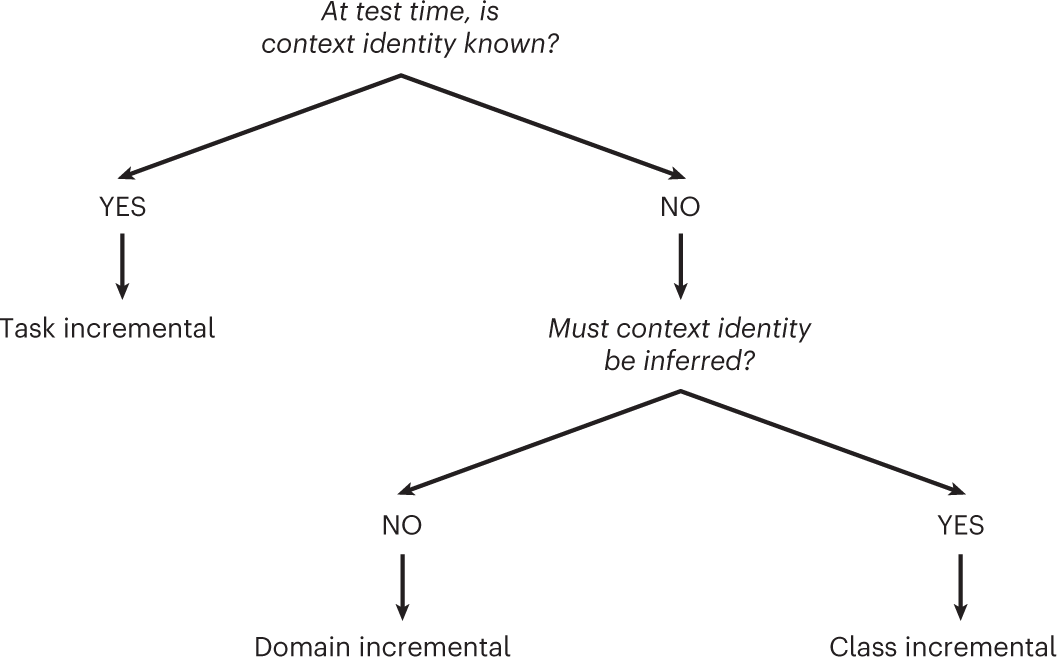

These different continual learning scenarios each have their "real-world relevance" and their own set of main challenges:

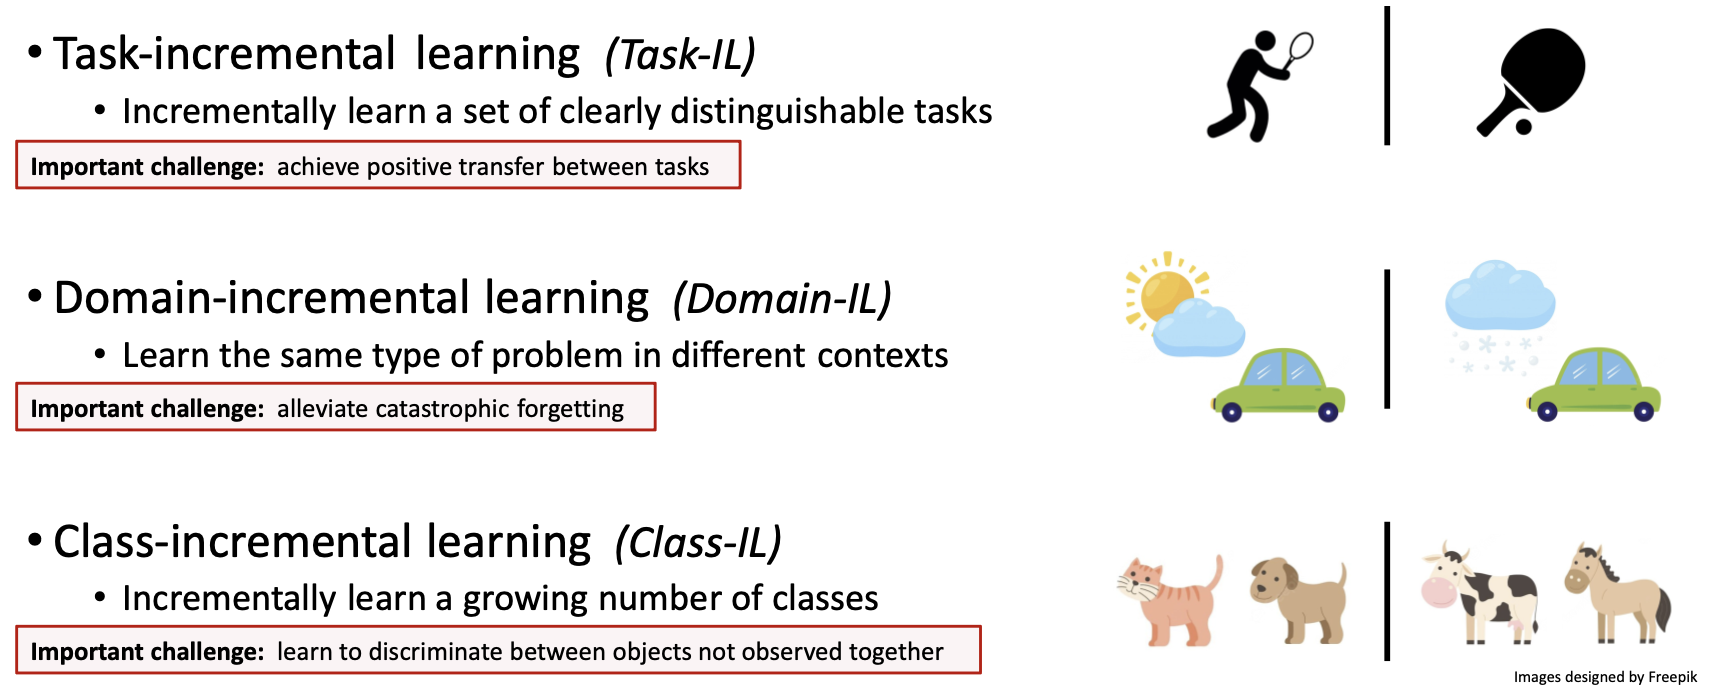

### ***QUESTION:***  What scenario was used for Permuted MNIST?

What type of 'scenario' was the permuted MNIST problem that we explored above? Was it task-incremental, domain-incremental or class-incremental? Try to motivate your answer.

In [ ]:
#@title Possible Answer

'''
The Permuted MNIST problem consisted of two contexts: normal MNIST (context 1) and MNIST
with permuted input images (context 2).

After learning both contexts, when the model was evaluated, the model was not told to
which context an image belongs (i.e., the model was not told whether the image to be
classified was permuted or not), but the model also did not need to identify to
which context an image belongs (i.e., the model did not need to predict whether
the image to be classified had permuted pixels or not; it only needed to predict
the original digit displayed in the image).
This thus means that the above Permuted MNIST problem was an example of a domain-incremental
learning problem.

Another way to motivate that this problem is an example of domain-incremental
learning, is to say that in both context 1 (normal MNIST) and context 2 (MNIST with
permuted input images), the 'type of problem' is the same (i.e., to identify the
digit displayed in the original image), but the 'domain' or 'context' is changing (i.e.,
the order/permutation in which the image pixels are presented).
''';

Now let's explore a **class-incremental learning** problem. For this we will no longer use Permuted MNIST (because it is a bit unintuitive to perform Permuted MNIST according to the class-incremental learning scenario), but we will use Split MNIST.

### Set up the benchmark: Split MNIST
We will split the MNIST dataset up in five contexts with two different classes per context.

In [ ]:
contexts = 5
classes_per_context = 2
# Generate labels-per-context
labels_per_context = [
    list(np.array(range(classes_per_context))+classes_per_context*context_id) for context_id in range(contexts)
]
# Split the train and test datasets up into sub-datasets, one for each context
train_datasets = []
test_datasets = []
for labels in labels_per_context:
    train_datasets.append(SubDataset(MNIST_trainset, labels))
    test_datasets.append(SubDataset(MNIST_testset, labels))

In [ ]:
# Visualize the contexts
figure, axis = plt.subplots(1, contexts, figsize=(3*contexts, 4))

for context_id in range(len(train_datasets)):
    plot_examples(axis[context_id], train_datasets[context_id], context_id=context_id)

Because we perform Split MNIST according to the class-incremental learning scenario, the goal is to train a neural network classifier that can distinguish between all ten MNIST digits (i.e., to learn a 10-way classifier).

### Set up the model
We use the same architecture for the deep neural network as before:

In [ ]:
# Specify the architectural layout of the network to use
fc_lay = 4        #--> number of fully-connected layers
fc_units = 40     #--> number of units in each hidden layer

In [ ]:
# Define the model
model = Classifier(image_size=config['size'], image_channels=config['channels'],
                   output_units=config['classes'],
                   fc_layers=fc_lay, fc_units=fc_units)

### Prepare for evaluation after each context
We will compare three of the same continual learning strategies as before (fine-tuning, EWC and replay), for sequentially training a deep neural network on the five contexts of Split MNIST. When we do this, we want to keep track of the performance of the model while it is sequentially trained on these different contexts. For that we will define some functions here.

As is common in the continual learning literature, we will evaluate the performance of the model only after finishing training on each new context. (But see [this paper](https://openreview.net/forum?id=Zy350cRstc6) for an interesting phenomenon that can be observed if we would evaluate the model on previous contexts after each training iteration on the new task. If we have time, we will have a look at this ourselves as well!)

In [ ]:
# Define a function to initiate a dict-object in which performance throughout training is logged.
def initiate_result_dict(n_contexts):
    '''Initiate <dict> with accuracy-measures to keep track of.'''
    result_dict = {}
    result_dict["acc per context"] = {}
    for i in range(n_contexts):
        result_dict["acc per context"]["context {}".format(i+1)] = []
    result_dict["average_contexts_so_far"] = []  # average accuracy over all contexts so far
    result_dict["average_all_contexts"] = []     # average accuracy over all contexts
    result_dict["context"] = []                  # number of contexts so far
    return result_dict

In [ ]:
def test_all(model, list_of_datasets, current_context, result_dict, test_size=None, verbose=True):
    '''Evaluate accuracy of a classifier (=[model]) on all contexts in [datasets].'''

    n_contexts = len(list_of_datasets)

    # Evaluate accuracy of model on all contexts
    precs = []
    for i in range(n_contexts):
        precs.append(test_acc(model, list_of_datasets[i], test_size=test_size))

    # Compute average accuracy both for all contexts seen so far, and for all contexts
    ave_so_far = sum([precs[context_id] for context_id in range(current_context)]) / current_context
    ave_all = sum([precs[context_id] for context_id in range(n_contexts)]) / n_contexts

    # Print results on screen
    if verbose:
        print(' => ave accuracy (contexts so far): {:.3f}'.format(ave_so_far))
        print(' => ave accuracy (all contexts):    {:.3f}'.format(ave_all))

    # Add results to [result_dict]
    if result_dict is not None:
        for i in range(n_contexts):
            result_dict['acc per context']['context {}'.format(i+1)].append(precs[i])
        result_dict['average_all_contexts'].append(ave_all)
        result_dict['average_contexts_so_far'].append(ave_so_far)
        result_dict['context'].append(current_context)

### Compare fine-tuning, EWC and replay on Split MNIST
For each strategy we will use the following training hyperparameters:

In [ ]:
# Training hyperparameters
iters = 100       #--> for how many iterations to train?
lr = 0.001        #--> learning rate
batch_size = 256  #--> size of mini-batches

#### Fine-tuning

In [ ]:
# Create a copy from the base-model
model_finetune = copy.deepcopy(model)

In [ ]:
# Initiate a `results_dict` to keep track of performance throughout the continual training.
result_dict_finetune = initiate_result_dict(contexts)

For fine-tuning, we can simply re-use the `train`-function we had defined above to train the model on a given dataset in "the standard way" (i.e., without using any specific continual learning strategy).

In [ ]:
# Sequentially train the model on all contexts using finetuning
for context_id in range(contexts):
    # - train the model on this context
    print('\nTrain on context {}:'.format(context_id+1))
    train(model_finetune, dataset=train_datasets[context_id], iters=iters, lr=lr,
          batch_size=batch_size)
    # - evaluate the performance of the model after training on this context
    test_all(model_finetune, test_datasets, context_id+1, result_dict_finetune)

In [ ]:
# Visualize performance on each context throughout the continual training
plot_list = []
for i in range(contexts):
    plot_list.append(result_dict_finetune["acc per context"]["context {}".format(i + 1)])
figure = plot_lines(
    plot_list, x_axes=result_dict_finetune["context"],
    line_names=['context {}'.format(i + 1) for i in range(contexts)],
    title="Fine-tuning", ylabel="Test Accuracy (%)",
    xlabel="Number of contexts trained so far", figsize=(10,5),
)

That doesn't look great! The performance on data from each context drops to zero as soon as the next context has been learned.

Can this be fixed with EWC or replay?



#### EWC

Let's first try EWC.

In [ ]:
# Create a copy from the base-model
model_ewc = copy.deepcopy(model)

In [ ]:
# Initiate a `results_dict` to keep track of performance throughout the continual training.
result_dict_ewc = initiate_result_dict(contexts)

In [ ]:
# Select a hyperparameter for EWC
ewc_lambda = 100

Also for EWC, we can re-use the `train`- and `estimte_fisher`-functions for EWC we had defined above:

In [ ]:
# Sequentially train the model on all contexts using EWC
for context_id in range(contexts):
    # Train the model on this context
    print('\nTrain on context {}:'.format(context_id+1))
    train_ewc(model_ewc, train_datasets[context_id], iters=iters, lr=lr, batch_size=batch_size,
              current_context=context_id+1, ewc_lambda=ewc_lambda)
    # Estimate/update the FI-matrix (which is stored as buffer in the network)
    estimate_fisher(model_ewc, train_datasets[context_id], n_samples=200)
    # Evaluate the performance of the model after training on this context
    test_all(model_ewc, test_datasets, context_id+1, result_dict_ewc)

In [ ]:
# Visualize performance on each context throughout the continual training
plot_list = []
for i in range(contexts):
    plot_list.append(result_dict_ewc["acc per context"]["context {}".format(i + 1)])
figure = plot_lines(
    plot_list, x_axes=result_dict_ewc["context"],
    line_names=['context {}'.format(i + 1) for i in range(contexts)],
    title="EWC", ylabel="Test Accuracy (%)",
    xlabel="Number of contexts trained so far", figsize=(10,5),
)

On this class-incremental learning problem, EWC does not seem to help!

#### Experience Replay

What about replay? Can using ER help to improve performance on this class-incremental learning problem?

In [ ]:
# Create a copy from the base-model
model_replay = copy.deepcopy(model)

In [ ]:
# Initiate a `results_dict` to keep track of performance throughout the continual training.
result_dict_replay = initiate_result_dict(contexts)

In [ ]:
# Select how many samples per class can be stored in the memory buffer
buffer_size_per_class = 20

Also for ER, we can re-use the `train`- and `fill_memory_buffer`-functions for ER we had defined above:

In [ ]:
# Sequentially train the model on all contexts using Experience Replay
memory_sets = []
buffer_dataset = None
for context_id in range(contexts):
    # - train the model on this context
    print('\nTrain on context {}:'.format(context_id+1))
    train_replay(model_replay, train_datasets[context_id], iters=iters, lr=lr,
                 batch_size=batch_size, current_context=context_id+1, buffer_dataset=buffer_dataset)
    # - update memory buffer
    classes_in_this_context = list(range(classes_per_context*context_id,
                                         classes_per_context*(context_id+1)))
    memory_sets = fill_memory_buffer(memory_sets, train_datasets[context_id],
                                     buffer_size_per_class=buffer_size_per_class,
                                     class_indeces=classes_in_this_context)
    buffer_dataset = MemorySetDataset(memory_sets)
    # - evaluate the performance of the model after training on this context
    test_all(model_replay, test_datasets, context_id+1, result_dict_replay)

In [ ]:
# Visualize performance on each context throughout the continual training
plot_list = []
for i in range(contexts):
    plot_list.append(result_dict_replay["acc per context"]["context {}".format(i + 1)])
figure = plot_lines(
    plot_list, x_axes=result_dict_replay["context"],
    line_names=['context {}'.format(i + 1) for i in range(contexts)],
    title="Experience Replay ({} samples per class)".format(buffer_size_per_class),
    ylabel="Test Accuracy (%)", xlabel="Number of contexts trained so far", figsize=(10,5),
)

Experience replay does help on this type of continual learning problem!

### Visual comparison

Let's make a plot of the performance of the three different methods that we tried:

In [ ]:
key = "average_contexts_so_far"
plot_list = [result_dict_finetune[key], result_dict_ewc[key], result_dict_replay[key]]
line_names = ['Fine-tuning', 'EWC', 'Experience Replay']
figure = plot_lines(
    plot_list, x_axes=result_dict_replay["context"], line_names=line_names,
    title="Comparison (performance on all contexts so far)",
    ylabel="Test Accuracy (%)", xlabel="Number of contexts trained so far", figsize=(10,5),
)

(Note that the lines of `fine-tuning` and `EWC` might well overlap almost completely.)

### ***CODING ASSIGNMENT:***  Combine EWC and replay
Train another model copy on the class-incremental version of Split MNIST, but now using *both* EWC and experience replay.

In [ ]:
# First make another copy of the randomly initialized base model
model_ewc_replay = copy.deepcopy(model)
# And initiate another `results_dict` to keep track of performance throughout training
result_dict_ewc_replay = initiate_result_dict(contexts)

To train with both EWC and experience replay, we need to define a new training function that can be used to the train the model on a new context using both methods at the same time:

In [ ]:
def train_ewc_replay(model, dataset, buffer_dataset, iters, lr, batch_size, ewc_lambda):
    pass
    # TO BE COMPLETED (tip: use the training functions of EWC and ER as example / starting point)

In [ ]:
#@title Possible Answer
def train_ewc_replay(model, dataset, iters, lr, batch_size, current_context,
                     ewc_lambda=100., buffer_dataset=None):
    '''Function to train a [model] on a given [dataset] using a combined approach of ER and EWC.'''

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))
    model.train()
    iters_left = 1
    iters_left_replay = 1
    progress_bar = tqdm.tqdm(range(1, iters+1))

    for batch_index in range(1, iters+1):
        optimizer.zero_grad()

        # Data from current context
        iters_left -= 1
        if iters_left==0:
            data_loader = iter(torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                           shuffle=True, drop_last=True))
            iters_left = len(data_loader)
        x, y = next(data_loader)
        y_hat = model(x)
        loss = torch.nn.functional.cross_entropy(input=y_hat, target=y, reduction='mean')
        accuracy = (y == y_hat.max(1)[1]).sum().item()*100 / x.size(0)

        # Replay data from memory buffer
        if buffer_dataset is not None:
            iters_left_replay -= 1
            if iters_left_replay==0:
                batch_size_to_use = min(batch_size, len(buffer_dataset))
                data_loader_replay = iter(torch.utils.data.DataLoader(buffer_dataset,
                                                                      batch_size_to_use,
                                                                      shuffle=True,
                                                                      drop_last=True))
                iters_left_replay = len(data_loader_replay)
            x_, y_ = next(data_loader_replay)
            y_hat_ = model(x_)
            loss_replay = torch.nn.functional.cross_entropy(input=y_hat_, target=y_,
                                                            reduction='mean')

        # Compute the EWC-regularization term, and add it to the loss
        if current_context>1:
            ewc_losses = []
            for n, p in model.named_parameters():
                n = n.replace('.', '__')
                mean = getattr(model, '{}_EWC_param_values'.format(n))
                fisher = getattr(model, '{}_EWC_estimated_fisher'.format(n))
                ewc_losses.append((fisher * (p-mean)**2).sum())
            ewc_loss = (1./2)*sum(ewc_losses)
        else:
            ewc_loss = 0.

        # Combine all three losses
        if buffer_dataset is not None:
            rnt = 1./current_context
            total_loss = rnt*loss + (1-rnt)*loss_replay + ewc_lambda*ewc_loss
        else:
            total_loss = loss + ewc_lambda*ewc_loss

        total_loss.backward()
        optimizer.step()
        progress_bar.set_description(
        '<CLASSIFIER> | training loss: {loss:.3} | training accuracy: {prec:.3}% |'
            .format(loss=total_loss.item(), prec=accuracy)
        )
        progress_bar.update(1)
    progress_bar.close()

Now test your training function by using it to continually train the deep neural network model on Split MNIST:

In [ ]:
# Select hyperparameter for EWC
ewc_lambda_with_replay = 10 # YOU CAN EXPLORE OTHER VALUES
# (if you want to do a new try, first 'reset' [model_ewc_replay] by running the command
#  `model_ewc_replay = copy.deepcopy(model)` at the top of the assignment)

# Sequentially train the model on all contexts using both EWC and Experience Replay
memory_sets = []
buffer_dataset = None
for context_id in range(contexts):

    # Train the model on this context
    print('\nTrain on context {}:'.format(context_id+1))
    train_ewc_replay(model_ewc_replay, train_datasets[context_id], iters=iters, lr=lr,
                     batch_size=batch_size, current_context=context_id+1,
                     ewc_lambda=ewc_lambda_with_replay, buffer_dataset=buffer_dataset)

    # Estimate/update the FI-matrix (which is stored as attribute in the network)
    estimate_fisher(model_ewc_replay, train_datasets[context_id], n_samples=200)

    # Update memory buffer
    classes_in_this_context = list(range(classes_per_context*context_id,
                                         classes_per_context*(context_id+1)))
    memory_sets = fill_memory_buffer(memory_sets, train_datasets[context_id],
                                     buffer_size_per_class=buffer_size_per_class,
                                     class_indeces=classes_in_this_context)
    buffer_dataset = MemorySetDataset(memory_sets)

    # Evaluate the performance of the model after training on this context
    test_all(model_ewc_replay, test_datasets, context_id+1, result_dict_ewc_replay)

And visualizing its performance:

In [ ]:
# Visualize performance on each context throughout the continual training
plot_list = []
for i in range(contexts):
    plot_list.append(result_dict_ewc_replay["acc per context"]["context {}".format(i + 1)])
figure = plot_lines(
    plot_list, x_axes=result_dict_ewc_replay["context"],
    line_names=['context {}'.format(i + 1) for i in range(contexts)],
    title="EWC (lambda{}) + Experience Replay ({} samples per class)".format(
        ewc_lambda_with_replay, buffer_size_per_class
    ), ylabel="Test Accuracy (%)", xlabel="Number of contexts trained so far", figsize=(10,5),
)

Is there a benefit of "EWC + Experience Replay" over only "Experience Replay"? Let's compare them more directly.

In [ ]:
key = "average_contexts_so_far"
plot_list = [result_dict_finetune[key], result_dict_ewc[key], result_dict_replay[key],
             result_dict_ewc_replay[key]]
line_names = ['Fine-tuning', 'EWC', 'Experience Replay', 'EWC + Experience Replay']
figure = plot_lines(
    plot_list, x_axes=result_dict_replay["context"], line_names=line_names,
    title="Comparison (performance on all contexts so far)",
    ylabel="Test Accuracy (%)", xlabel="Number of contexts trained so far", figsize=(10,5),
)

## **Bonus Part:**  The stability gap
So far we have only evaluated the performance of the model after finishing training the model on each context. This is the typical approach in the continual learning literature.

But we already mentioned that we can observe an interesting phenomenon when we evaluate the performance of the model also *during* training on a new context. This phenomenon is called the "stability gap" and was first described by [De Lange et al. (2023, *ICLR*)](https://openreview.net/forum?id=Zy350cRstc6). Let's have a look!

### Set up the benchmark: Rotated MNIST
To illustrate this phenomenon, we will use yet another popular MNIST-based continual learning benchmark: Rotated MNIST.

In this benchmark, in each context the MNIST digits are rotated by a different amount.

In [ ]:
# Two contexts is enough to illustrate the stability gap
contexts = 2

# Specify for each context the rotations to use (with no rotation for the first context)
rotations = [0, -150]

# Specify for each context the transformed train- and testset
train_datasets = []
test_datasets = []
for context_id, rotation in enumerate(rotations):
    train_datasets.append(TransformedDataset(
        MNIST_trainset, transform=transforms.RandomRotation(degrees=(rotation,rotation)),
    ))
    test_datasets.append(TransformedDataset(
        MNIST_testset, transform=transforms.RandomRotation(degrees=(rotation,rotation)),
    ))

In [ ]:
# Visualize the contexts
figure, axis = plt.subplots(1, contexts, figsize=(3*contexts, 4))

for context_id in range(len(train_datasets)):
    plot_examples(axis[context_id], train_datasets[context_id], context_id=context_id)

We will perform this benchmark according to the domain-incremental learning scenario (i.e., at test time, the amount of rotation is not known, but also does not need to inferred; the only task is to identify the digit).

### Set up the model
The model that we will train on these two contexts is again a relatively simple fully connected neural network:

In [ ]:
# Specify the architectural layout of the network to use
fc_lay = 3        #--> number of fully-connected layers
fc_units = 100    #--> number of units in each hidden layer

In [ ]:
# Define the model
model = Classifier(image_size=config['size'], image_channels=config['channels'],
                   output_units=config['classes'],
                   fc_layers=fc_lay, fc_units=fc_units)

### Train with replay and *continual evaluation*
As continual learning strategy we are going to use experience replay. We already saw that such replay is able to prevent most catastrophic forgetting of a previous context *when evaluated at the end of training on a new context*.

Now we are going to see what happens when we use replay and evaluate the performance on the previous context *after every training iteration*.

To make this possible, we need to define a new training function. This training function should use experience replay, and it should also allow for evaluating the model after each training iteration:

In [ ]:
def train_and_evaluate_replay(model, trainset, iters, lr, batch_size, current_context,
                              testset, test_size=256, performance=[], buffer_dataset=None):
    '''Function to train a [model] on a given [dataset] using ER (sampled from [buffer_dataset]),
    while evaluating after each training iteration on [testset].'''

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))
    model.train()
    iters_left = 1
    iters_left_replay = 1
    progress_bar = tqdm.tqdm(range(1, iters+1))

    for batch_index in range(1, iters+1):
        optimizer.zero_grad()

        # Data from current context
        iters_left -= 1
        if iters_left==0:
            data_loader = iter(torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                                           shuffle=True, drop_last=True))
            iters_left = len(data_loader)
        x, y = next(data_loader)
        y_hat = model(x)
        loss = torch.nn.functional.cross_entropy(input=y_hat, target=y, reduction='mean')

        # Calculate test accuracy (in %)
        accuracy = test_acc(model, testset, test_size=test_size, batch_size=batch_size)
        performance.append(accuracy)

        # Replay data from memory buffer
        if buffer_dataset is not None:
          iters_left_replay -= 1
          if iters_left_replay==0:
              batch_size_to_use = min(batch_size, len(buffer_dataset))
              data_loader_replay = iter(torch.utils.data.DataLoader(buffer_dataset,
                                                                    batch_size_to_use, shuffle=True,
                                                                    drop_last=True))
              iters_left_replay = len(data_loader_replay)
          x_, y_ = next(data_loader_replay)
          y_hat_ = model(x_)
          loss_replay = torch.nn.functional.cross_entropy(input=y_hat_, target=y_, reduction='mean')

        # Combine both losses to approximate the joint loss over both contexts
        # (i.e., the loss on the replayed data has weight proportional to number of contexts so far)
        if buffer_dataset is not None:
            rnt = 1./current_context
            total_loss = rnt*loss + (1-rnt)*loss_replay
        else:
            total_loss = loss

        total_loss.backward()
        optimizer.step()
        progress_bar.set_description(
        '<CLASSIFIER> | training loss: {loss:.3} | test accuracy: {prec:.3}% |'
            .format(loss=total_loss.item(), prec=accuracy)
        )
        progress_bar.update(1)
    progress_bar.close()

Choose the training hyperparameters:

In [ ]:
iters = 100       #--> for how many iterations to train?
lr = 0.01         #-->learning rate
batch_size = 128  #--> size of mini-batches

Train on the first context:

In [ ]:
# Define a list to keep track of the performance on context 1 after each iteration
performance_task1 = []

# Train on context 1
print('Train on Context 1:')
train_and_evaluate_replay(model, trainset=train_datasets[0], iters=iters, lr=lr,
                          batch_size=batch_size, current_context=1,
                          testset=test_datasets[0], performance=performance_task1)

Fill the replay buffer:

In [ ]:
# How much samples to store in the memory buffer for each class?
buffer_size_per_class = 200

# Fill the memory buffer
memory_sets = []
memory_sets = fill_memory_buffer(memory_sets, train_datasets[0],
                                 buffer_size_per_class=buffer_size_per_class,
                                 class_indeces=list(range(10)))
buffer_dataset = MemorySetDataset(memory_sets)

Train on the second context, while continuing to evaluate after each iteration the performance on the first context:

In [ ]:
# Train on context 2
print('Train on Context 2:')
train_and_evaluate_replay(model, trainset=train_datasets[1], iters=iters, lr=lr,
                          batch_size=batch_size, current_context=2,
                          testset=test_datasets[0], performance=performance_task1,
                          buffer_dataset=buffer_dataset)

### Visualize
Visualize the per-iteration performance on test data from the first context:

In [ ]:
# Plot per-iteration performance curve
figure = plot_lines(
    [performance_task1], x_axes=list(range(2*iters)),
    line_names=['Experience Replay'],
    title="Performance on Context 1 throughout training",
    ylabel="Test Accuracy (%) on Context 1",
    xlabel="Total number of training iterations", figsize=(10,5),
    v_line=iters, v_label='Context switch', ylim=(60,100),
)

**When the network starts training on the second context, it temporarily forgets the first context before later 're-learning' it!**

That is an intriguing learning dynamics. And it turns out that this "forget-then-relearn" behaviour is very typical for most of the state-of-the-art continual learning methods for deep neural networks.

This raises many interesting questions:
- These learning dynamics seem ***unintuitive*** and ***inefficient***. Would it not be a better strategy to simply prevent forgetting in the first place, rather than having to relearn later on? See [this paper](https://arxiv.org/abs/2311.04898) for some further thoughts and arguments on this.
- Can we understand the underlying reasons for the stability gap?
- **Do humans suffer from a stability gap when learning something new?**
  - If so, could the stability gap in deep neural networks be a good computational model for studying the computational principles underlying these dynamics?
  - If not, what is different in the continual learning strategy that is used by our brain that can explain this difference with state-of-the-art continual learning methods for deep neural networks?
- ...